In [1]:
import warnings
warnings.simplefilter('ignore')

import logging
import numpy as np
import pandas as pd
from numpy.random import RandomState
import matplotlib.pyplot as plt


from sklearn.decomposition import NMF


from os import listdir,getcwd
from os.path import isfile, join
from PIL import Image, ImageOps
import os

In [2]:
import shutil

In [3]:
shutil.unpack_archive('/content/drive/MyDrive/DataSets/images.tar.gz')

In [4]:
def get_data_matrix(test=False,Length=100,Width=100,mypath="images/"):

    files = [join(mypath,f) for f in listdir(mypath) if isfile(join(mypath, f)) and f[0] != '.']
    if mypath + '/.DS_Store' in files:
        files.remove(mypath + '/.DS_Store')

    if test:
        print("test data")
        files=files[9000:10000]

    else:
        print("training data")
        files=files[0:9000]

    print(len(files))
    X=np.zeros((len(files),Length*Width))
    for i,file in enumerate(files):
        img = Image.open(file).resize((Width, Length))
        img =  ImageOps.grayscale(img)

        I=np.array(img)

        X[i,:]=I.reshape(1,-1)
    return X

In [7]:
def reshape_row(x) :
    plt.imshow(x.reshape(Length,Width),cmap="gray")


In [8]:
def threshold(similar_distance,max_=0.1,min_=0):
    dataset_index=np.where(np.logical_and(similar_distance>min_ ,similar_distance<max_))[0]
    query_index=similar_index[np.logical_and(similar_distance>min_ ,similar_distance<max_)]
    return dataset_index,query_index

In [9]:
def plot_data_query(dataset_index,query_index,N):
    for data_sample,query_sample in zip(dataset_index[0:N],query_index[0:N]):

        plt.figure(figsize=(10,4))
        plt.subplot(1,2,1)
        reshape_row(X[data_sample])
        plt.title("dataset sample {}".format(data_sample))
        plt.subplot(1,2,2)
        reshape_row(X_q[query_sample])
        plt.title("query sample match {}".format(query_sample))
        plt.show()

        print("-----------------------------------------------------")

In [10]:
Length,Width=100,100
X=get_data_matrix(test=False,Length=100,Width=100,mypath="images")
X.shape

training data
9000


(9000, 10000)

In [11]:
n_components=10

In [12]:
nmf_estimator = NMF(n_components=n_components, tol=5e-3,max_iter=2000)
nmf_estimator.fit(X)  # original non- negative dataset

NMF(max_iter=2000, n_components=10, tol=0.005)

In [13]:
H = nmf_estimator.components_

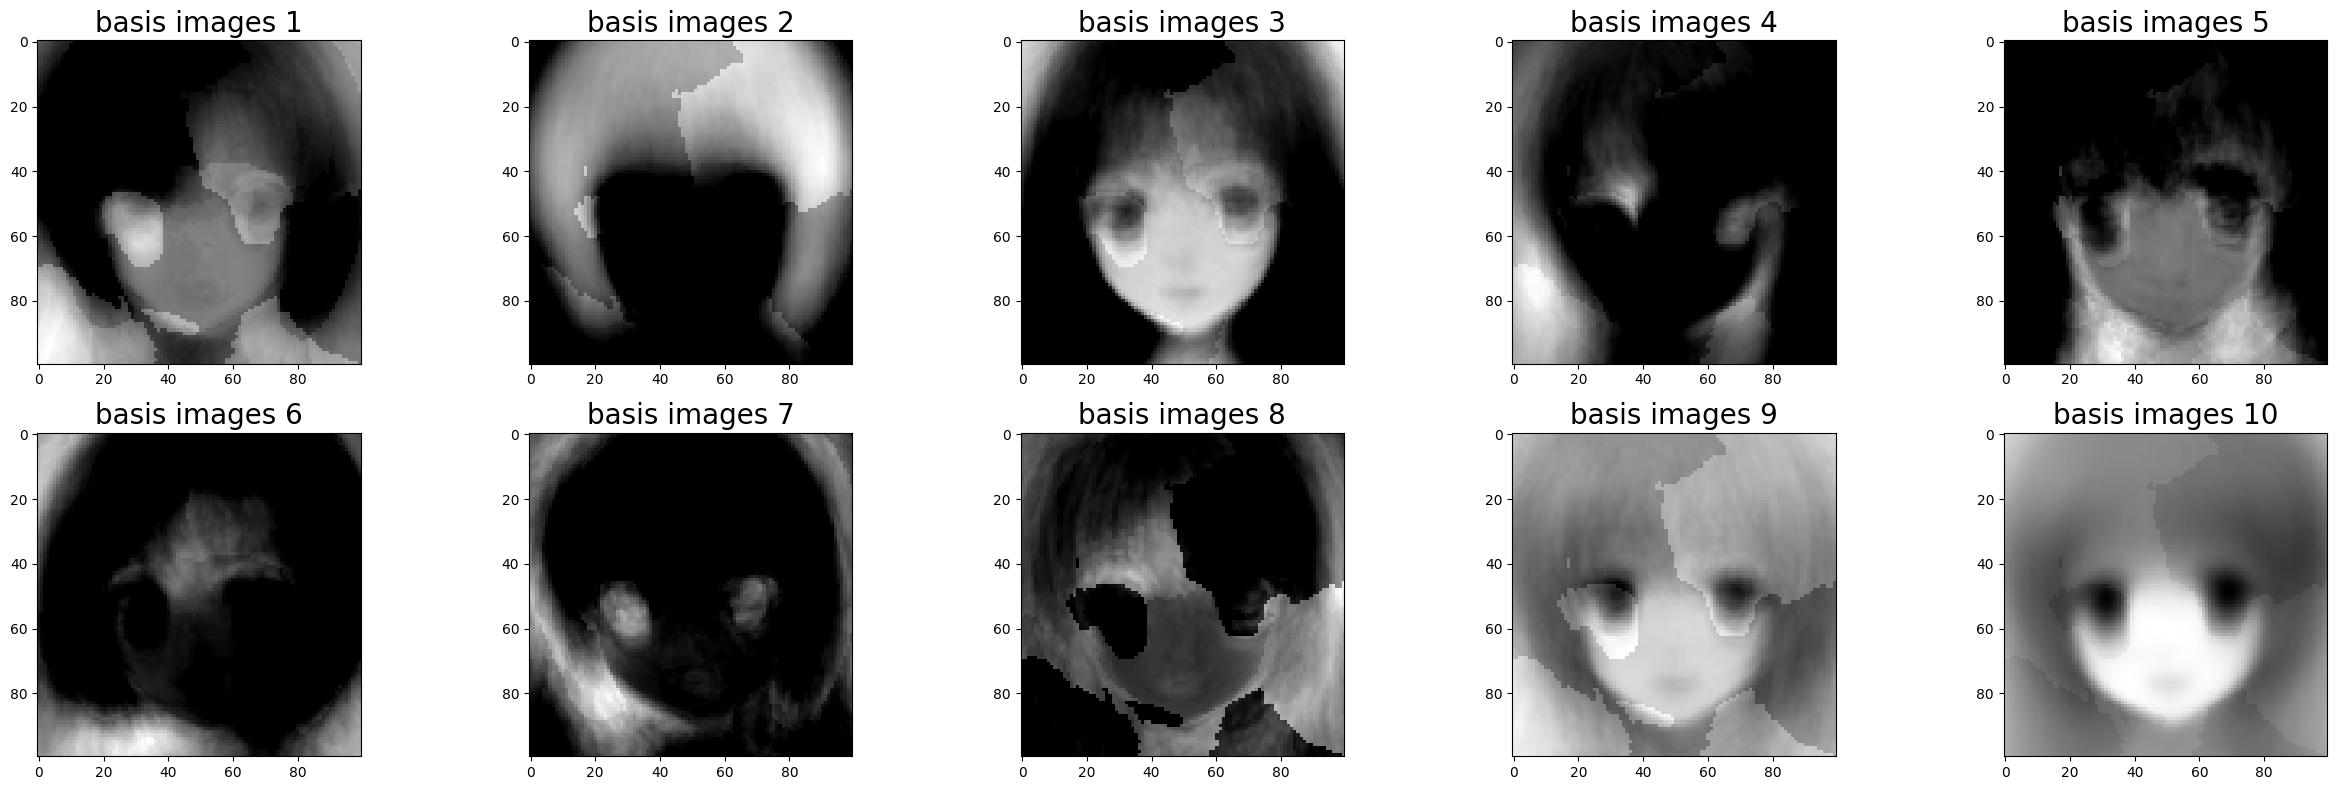

In [14]:
plt.figure(figsize=(25, 8))

for i,h in enumerate(H):
    plt.subplot(2, 5, i+1)
    reshape_row(h)
    plt.title("basis images {}".format(str(i+1)), fontsize=20)

plt.tight_layout()

In [15]:
W = nmf_estimator.transform(X)

In [16]:
W.shape

(9000, 10)

Text(0.5, 1.0, 'encodings for image 1 ')

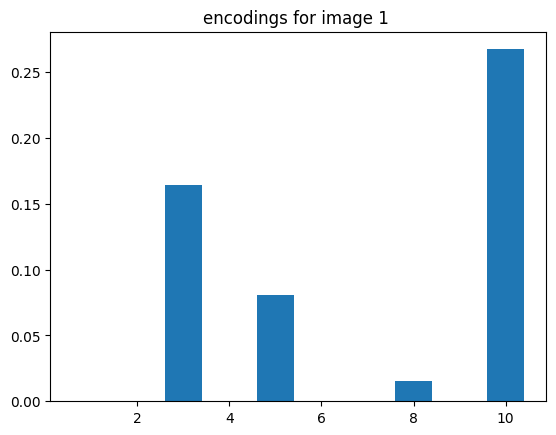

In [17]:
i=0
w=W[i,:]

plt.bar([n+1 for n in range(len(w))],w)
plt.title("encodings for image {} ".format (i+1))

Text(0.5, 1.0, 'Dissimilar basis 9')

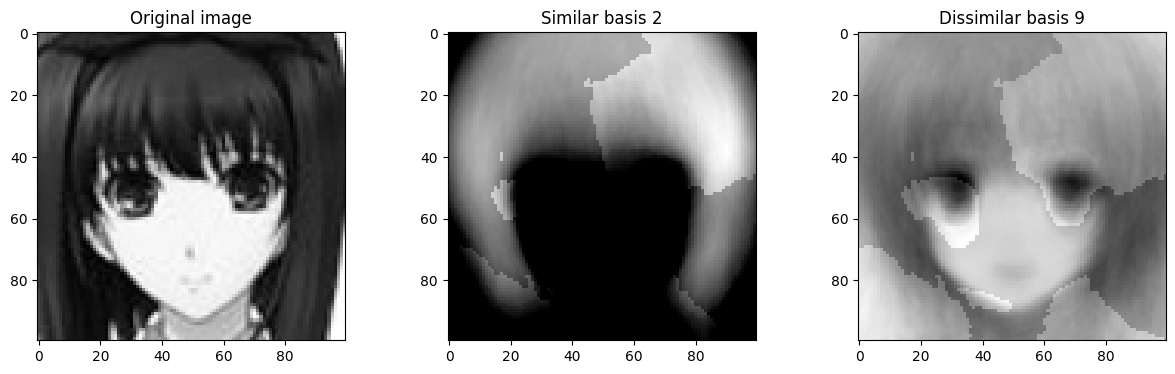

In [18]:
plt.figure(figsize=(15,4))

plt.subplot(131)
reshape_row(X[i,:])
plt.title("Original image")

plt.subplot(132)
reshape_row(H[1,:])
plt.title("Similar basis 2")

plt.subplot(133)
reshape_row(H[8,:])
plt.title("Dissimilar basis 9")

In [19]:
Xhat=nmf_estimator.inverse_transform(W)

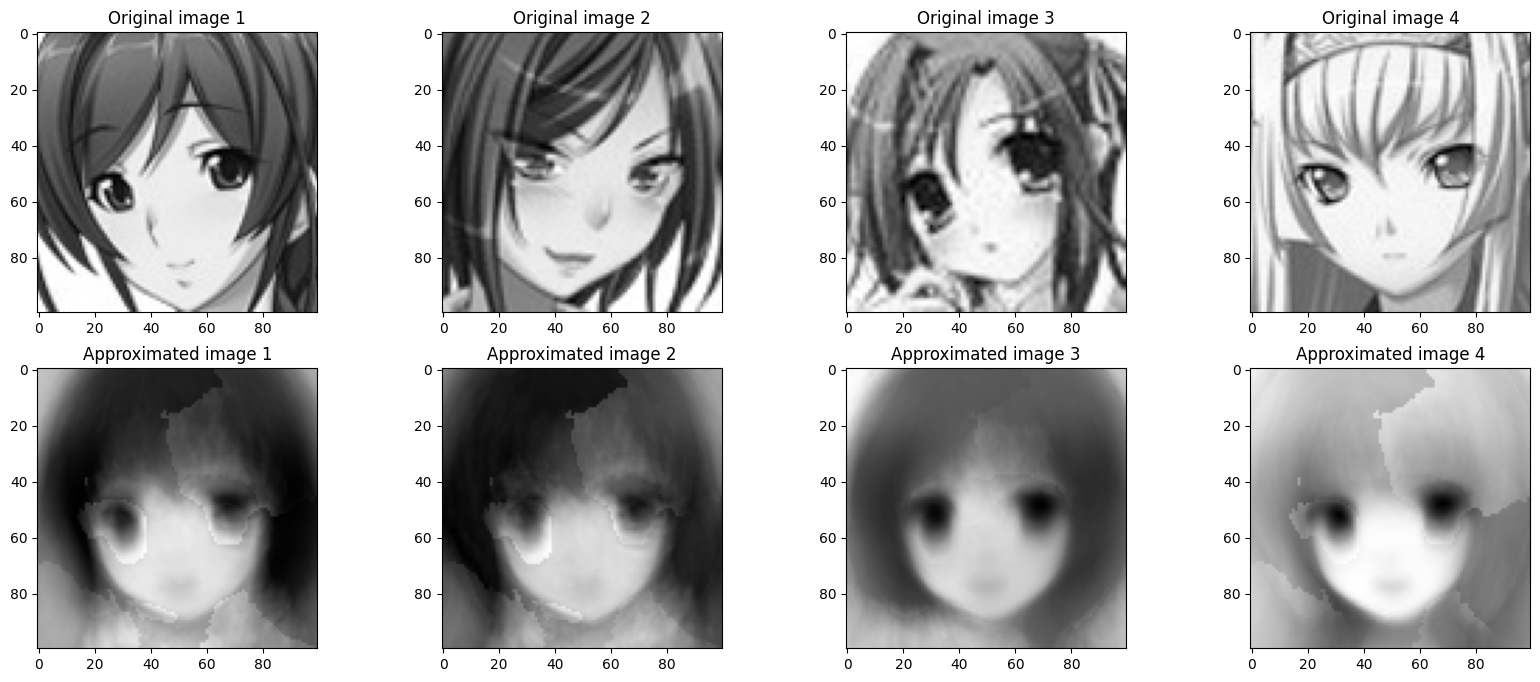

In [20]:
plt.figure(figsize=(20,8))

for i in range(1,5):
    plt.subplot(2,4,i)
    reshape_row(X[i])
    plt.title(f"Original image {i}")

    plt.subplot(2,4,i+4)
    reshape_row(Xhat[i])
    plt.title(f"Approximated image {i}")

In [21]:
Xhat_M=W@H

In [22]:
Xhat[0,:10], Xhat_M[0,:10]

(array([165.72480155, 162.74565765, 160.30079083, 158.88872025,
        156.13258   , 152.02101951, 147.26616542, 143.48690769,
        140.1612235 , 133.71147218]),
 array([165.72480155, 162.74565765, 160.30079083, 158.88872025,
        156.13258   , 152.02101951, 147.26616542, 143.48690769,
        140.1612235 , 133.71147218]))

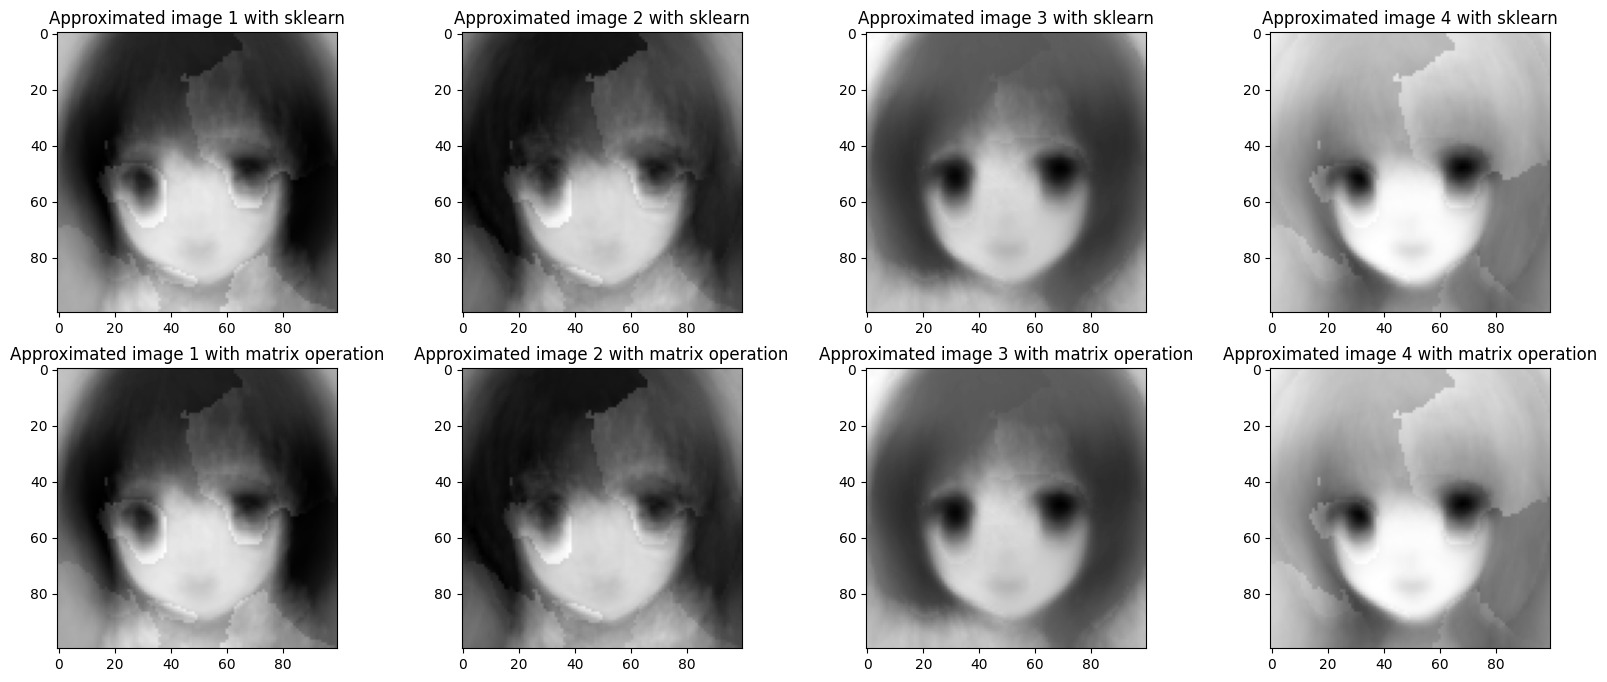

In [23]:
plt.figure(figsize=(20,8))

for i in range(1,5):
    plt.subplot(2,4,i)
    reshape_row(Xhat[i])
    plt.title(f"Approximated image {i} with sklearn")

    plt.subplot(2,4,i+4)
    reshape_row(Xhat_M[i])
    plt.title(f"Approximated image {i} with matrix operation")

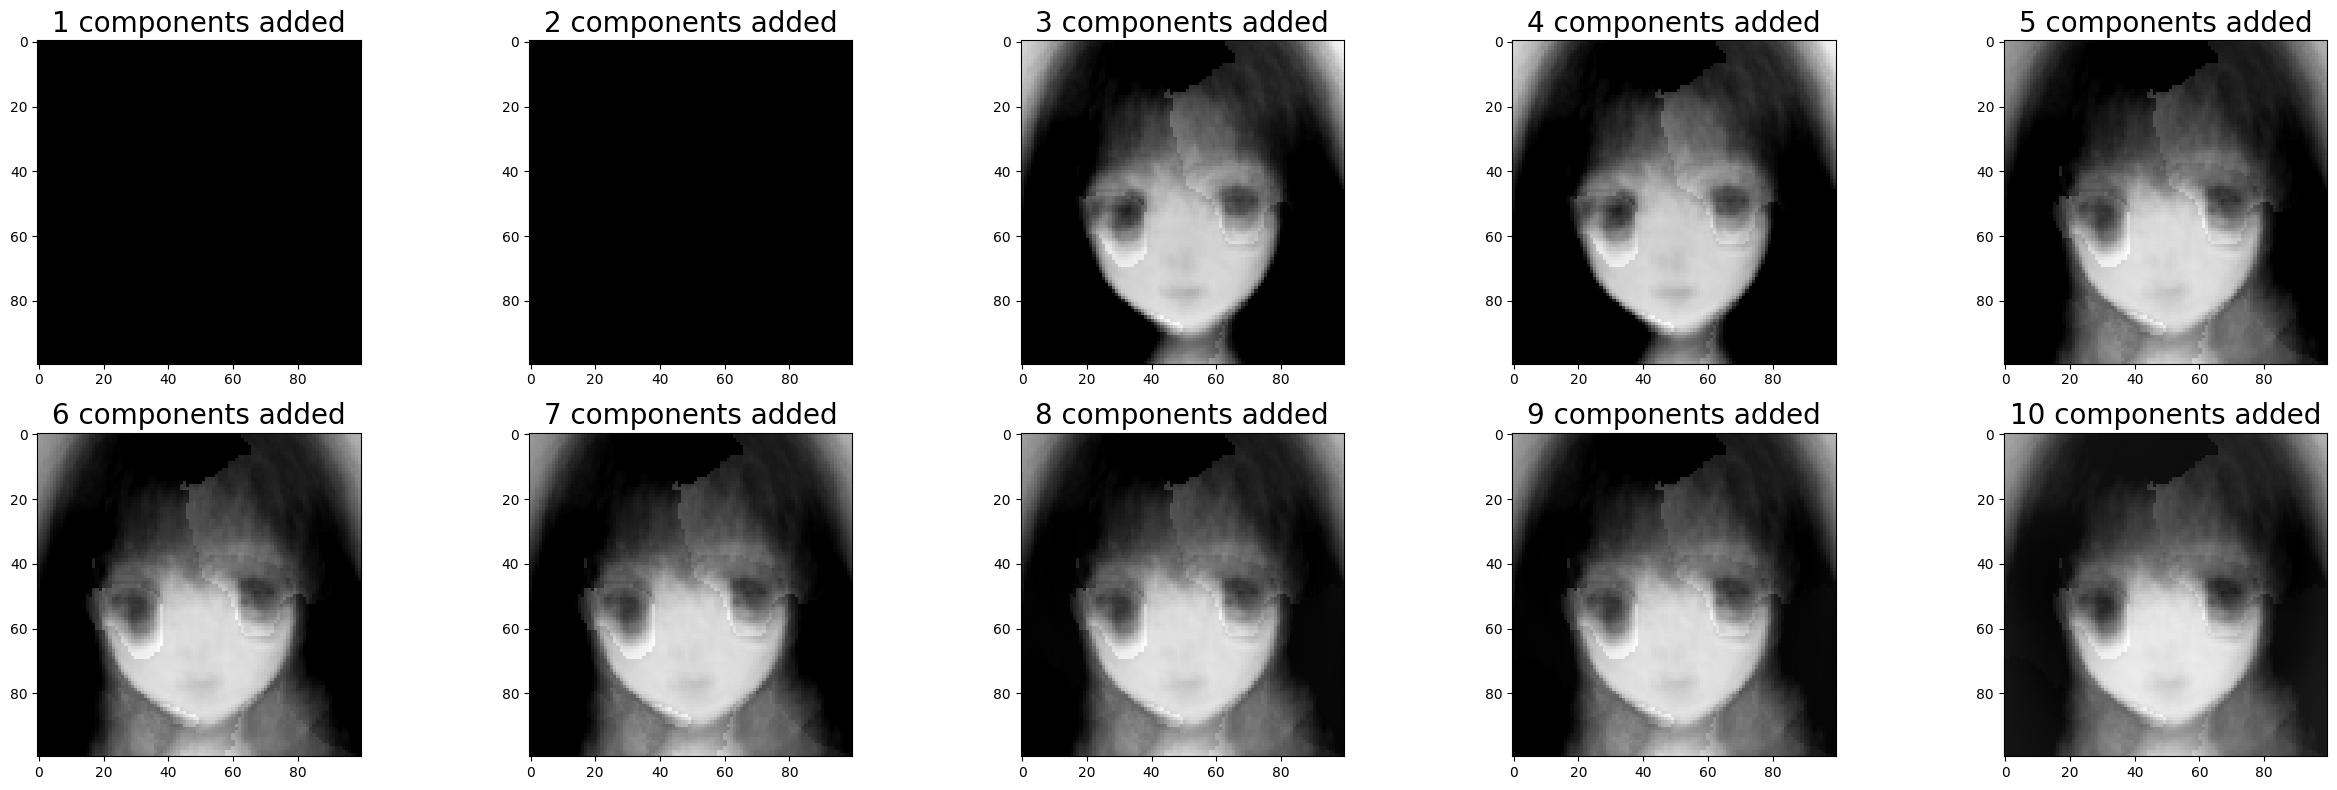

In [24]:
# initialize an image array with 10000 zeros which will be reshaped as 100x100
image=np.zeros((1,10000))

plt.figure(figsize=(25,8))
for i, (w_, h) in enumerate(zip(w, H)):

    # w is the encoding vector of the first image in X
    # reconstruction of the image is a linear combination of H
    plt.subplot(2,5,i+1)
    image += w_*h
    reshape_row(image)
    plt.title(f"{i+1} components added", fontsize=20)
plt.tight_layout()

# Image Retrieval System

In [25]:
X_q=get_data_matrix(test=True,Length=100,Width=100,mypath="images")
X_q.shape

test data
1000


(1000, 10000)

In [26]:
W_q=nmf_estimator.transform(X_q)
W_q.shape

(1000, 10)

In [27]:
from sklearn.metrics import pairwise_distances

In [28]:
# calculates the pairwise distance between the NNMF encoded version of
# the original dataset W and the encoded version of the query dataset W_q
D=pairwise_distances(W,W_q,metric='cosine')

In [29]:
D.shape

(9000, 1000)

In [30]:
similar_index=np.argmin(D, axis=1)

In [31]:
similar_distance=np.min(D, axis=1)

Text(0.5, 1.0, 'Distance values')

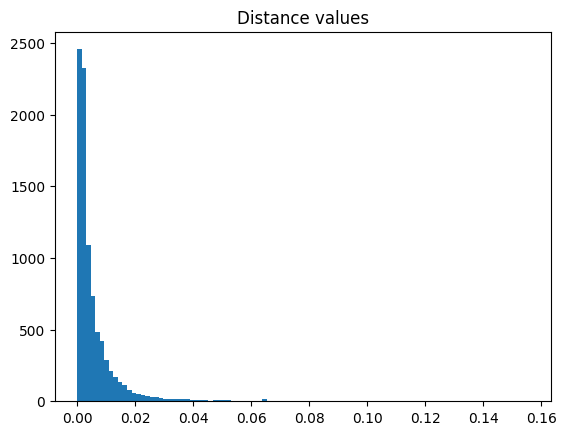

In [32]:
plt.hist(similar_distance,bins=100)
plt.title("Distance values")

In [33]:
dataset_index,query_index=threshold(similar_distance,max_=0.00001,min_=0)

In [34]:
dataset_index.shape, query_index.shape


((34,), (34,))

In [35]:
dataset_index[:10]

array([ 439, 1109, 1261, 1354, 1449, 1506, 1772, 1968, 2256, 2979])

In [36]:
query_index[:10]

array([493, 850, 123, 224, 377, 850, 244, 407, 850, 797])

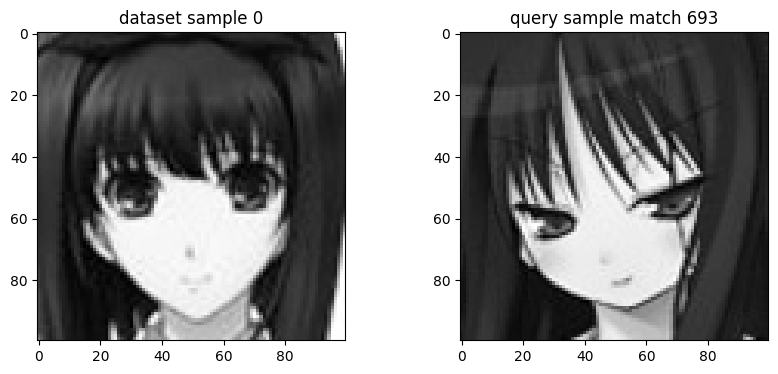

-----------------------------------------------------


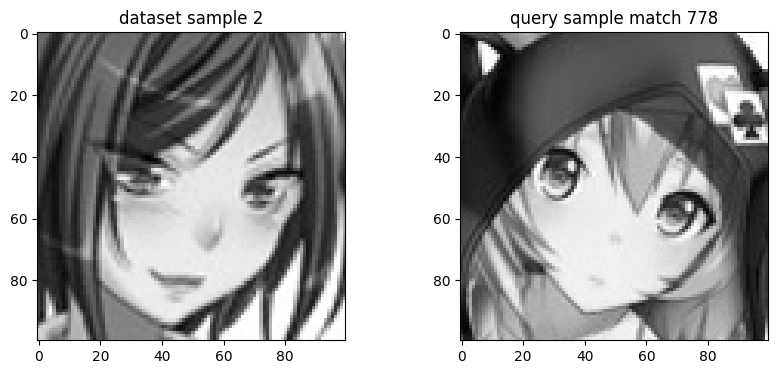

-----------------------------------------------------


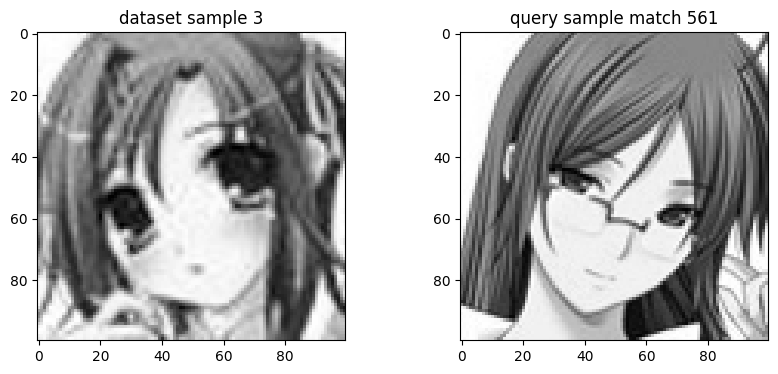

-----------------------------------------------------


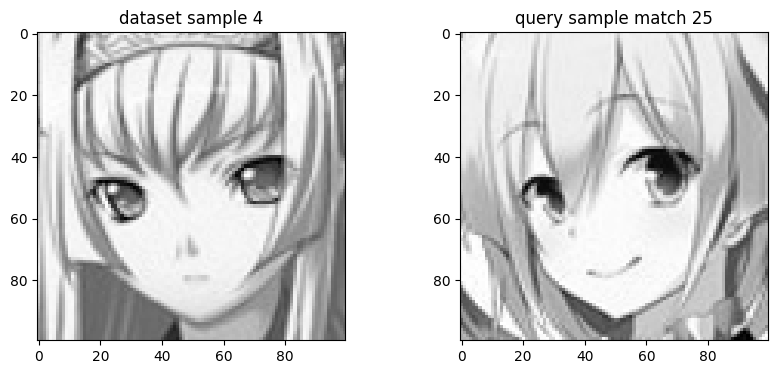

-----------------------------------------------------


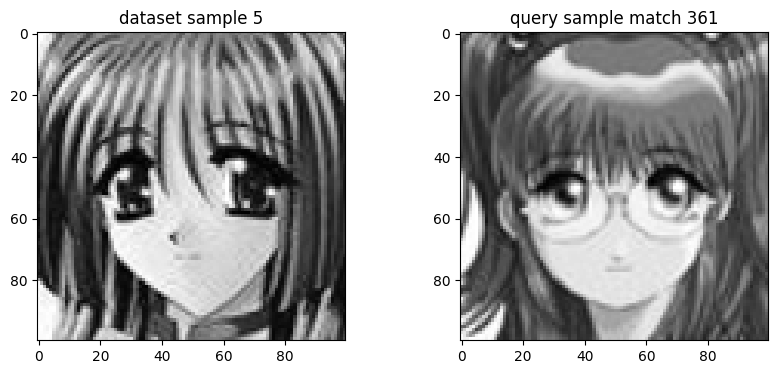

-----------------------------------------------------


In [37]:
dataset_index,query_index=threshold(similar_distance,max_=0.005,min_=0.00001)
plot_data_query(dataset_index,query_index,5)

In [38]:
from sklearn.datasets import fetch_olivetti_faces

rng = RandomState(0)
data = fetch_olivetti_faces(shuffle=True, random_state=rng)
X = data.images

downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to /root/scikit_learn_data


In [39]:
image_shape = (64, 64)

def plot_faces(title, images, n_col, n_row, cmap=plt.cm.gray):
    fig, axs = plt.subplots(
        nrows = n_row,
        ncols = n_col,
        figsize = (2.0*n_col, 2.3*n_row),
        facecolor='white',
        constrained_layout=True)

    fig.set_constrained_layout_pads(w_pad=0.01, h_pad=0.02, hspace=0, wspace=0)
    fig.set_edgecolor("black")
    fig.suptitle(title, size=16)
    for ax, vec in zip(axs.flat, images):
        vmax = max(vec.max(), -vec.min())
        im = ax.imshow(
            vec.reshape(image_shape),
            cmap=cmap,
            interpolation="nearest",
            vmin=-vmax,
            vmax=vmax)
        ax.axis('off')

    fig.colorbar(im, ax=axs, orientation='horizontal', shrink=0.99,
                aspect=40, pad=0.01)
    plt.show()

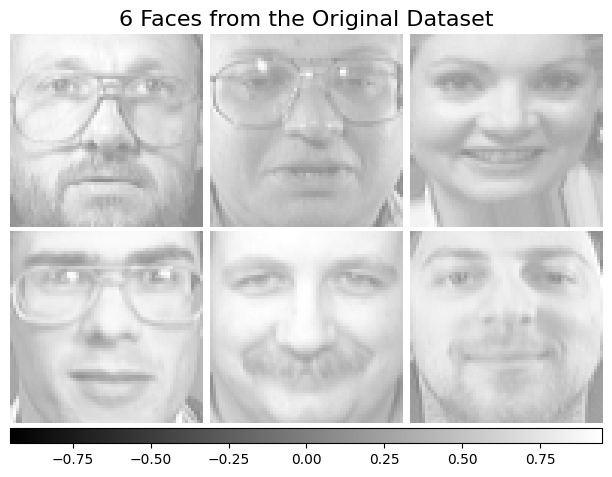

In [40]:
plot_faces("6 Faces from the Original Dataset", X[:6], 3, 2)

In [41]:
X_r = X[:300].reshape((300, 64*64))
X_q = X[300:].reshape((100, 64*64))

nmf = NMF(n_components=10, tol=5e-3,max_iter=2000)
X_r_W = nmf.fit_transform(X_r)
X_q_W = nmf.fit_transform(X_q)

In [49]:
from sklearn.metrics import pairwise_distances

D = pairwise_distances(X_r_W, X_q_W, metric='cosine')

In [ ]:
#Calculate the pairwise distances between face encodings from the original and query dataset, store the result in D.
H = nmf.components_
plot_faces("Basis from dataset", H, 3, 2)

#For all rows in the pairwise distance matrix, output their smallest distances as similar_distance, and the index associated with the smallest distances as similar_index

similar_index = np.argmin(D, axis=1)
similar_distance = np.min(D, axis=1)
W = nmf.transform(X)
w6 = W[:6, :] # picking the first 6 encodings

X_hat = nmf.inverse_transform(w6)
plot_faces("6 Reconstructed faces using inverse_transform", X_hat, 3, 2)

#Use the similar_distance as input for the threshold function. You can specify the min and max threshold for the distances. Return the index of the original dataset and the query dataset that satisfy the specified threshold.
#Use plot_data_query to plot the first 5 pairs of face images that our image retrieval system "views" as similar.

o_index, q_index = threshold(similar_distance)

Length=64
Width=64
plot_data_query(o_index, q_index, 5)

X_hat_M = w6@H
plot_faces("6 Reconstructed faces using matrix operations", X_hat_M, 3,2)
print("-------------------------------------------------------")
plot_faces("6 Reconstructed faces using inverse_transform", X_hat, 3, 2)
